In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from pathlib import Path

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM

Using TensorFlow backend.


## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [3]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

## Settings

In [4]:
data_size = 2000000
data_mask = np.zeros(se.shape[0]).astype(bool)

data_mask[:data_size] = True

train = False
test = False

if train:
    data_mask = se['train']
    
if test: 
    data_mask = se['test']

data_size = np.count_nonzero(data_mask)


In [5]:
print(data_size)

2000000


In [6]:
test_matrix = np.load(f"percentage_offsets_check.npy").T

In [7]:
test_matrix.shape

(3920087, 2)

In [8]:
(test_matrix[:,0].astype(int)[500000:2000000] == se.index.values[500000:2000000]).all()

True

In [9]:
(test_matrix[data_mask,1] == se.loc[:,'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'][data_mask].values).all()


True

In [10]:
# test_length = np.count_nonzero(se['test'])

# test_mask = se['test']

In [11]:
# 1st dimention is number of data points
# 2nd dimention is going back in time (in 10 min increments)
# 3rd dimention is prev-next segments

width_array = [
             'prev_segment_code_11',
             'prev_segment_code_10',
             'prev_segment_code_9',
             'prev_segment_code_8',
             'prev_segment_code_7',
             'prev_segment_code_6',
             'prev_segment_code_5', 
             'prev_segment_code_4', 
             'prev_segment_code_3', 
             'prev_segment_code_2', 
             'prev_segment_code_1', 
             'segment_code',
             'next_segment_code_1',
             'next_segment_code_2',
             'next_segment_code_3',
             'next_segment_code_4',
             'next_segment_code_5',
             'next_segment_code_6',
             'next_segment_code_7',
             'next_segment_code_8',
             'next_segment_code_9',
             'next_segment_code_10',
             'next_segment_code_11',
            ]

means = np.empty((data_size, 25, len(width_array))).astype(float)
counts = np.empty((data_size, 25, len(width_array))).astype(int)

index = np.empty((data_size)).astype(int)

for idx, code in enumerate(tqdm(width_array)):
    
    matrix = np.load(f"mtx_{code}_last_25_10_2nd.npy")
    
#     matrix = matrix[se.index.values[:np.argmax(se.index.values>=3920086)],:]
    

    means[:,:,idx] = matrix[data_mask,1:26].astype(float)
    counts[:,:,idx] = matrix[data_mask,26:].astype(int)
    
    if idx == 0:
        index = matrix[data_mask,0].astype(int)
            
#     print(".", end="", flush=True)
        
  
    

In [12]:
# se = se[:np.argmax(se.index.values>=3920086)]

In [13]:

print((index == se.index[data_mask]).all())


True


In [14]:
def calc_slice(width, time, width_offset=0, time_offset=0):
    centre = int(len(width_array)/2) + 1
    centre += width_offset
    
    return np.s_[:,2+time_offset:time+3+time_offset,centre-width:centre+width+1]


In [15]:
def calc_offsets(means, counts, slices, axis, column_name, mask_threshold):
    
    mask = np.sum(counts[slices], axis=axis) > mask_threshold
    
    threshold_pass_fraction = np.count_nonzero(mask)/len(mask)
    
    if  threshold_pass_fraction < 0.25:
        raise ValueError('not enough data passing threshold')
    
    print(f"Approximately {threshold_pass_fraction*100:0.2f}% pass the threshold")
    
    data = means[slices][mask]
    
    weights = counts[slices][mask]
    
    masked_data = np.ma.masked_array(data, np.isnan(data))
    
    if column_name is not None:    
        se[column_name] = 0

        se.loc[mask, column_name] = np.ma.average(masked_data, axis=axis, weights=weights)
        
        return
    
    offsets = np.zeros(counts.shape[0])
    
    offsets[mask] = np.ma.average(masked_data, axis=axis, weights=weights)
    
    return offsets, threshold_pass_fraction, np.mean(np.sum(weights, axis=axis))

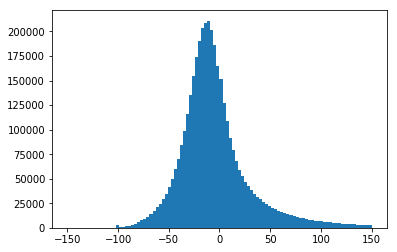

In [16]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));
# plt.hist(se['full_mean_minus_recent_15'], bins=100, range=(-150,150), alpha=0.5);

In [17]:
#Width of 2 and time of 100 with a threshold of 40

calc_slice(2,10)

bus_counts = np.sum(counts[calc_slice(2,10)], axis=(1,2))

dense_mask = (bus_counts>=40)

print(f"Fraction over 40: {(bus_counts>=40).sum()/bus_counts.shape[0]}")

Fraction over 40: 0.613744


Text(0.5, 1.0, 'Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments')

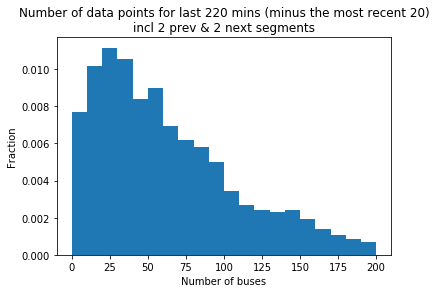

In [18]:
plt.hist(bus_counts, bins=20, range=(0,200), density=True);
plt.xlabel("Number of buses")
plt.ylabel("Fraction")
plt.title("Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments")

In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next

# Thoughts on the defaults:
# - Set to zero (fast but doesn't contain much data)
# - Set to v sparce prediction (probably better)
# - Try to predict diff between v sparse mean and truth, 
#              set empty to zero and values to diff from 
#              v sparse mean

# Other ideas:
# - When making the offsets going one stop furhter previous than next 
#              (as prev' seems to be a better predictor)
# - Try a stride length of 2 both in time and down the road
# - Try a little less dense...
st_offsets_dense = np.zeros((data_size, 7, 7))

for i in range(7):
    for j in range(-3,4,1):

        st_offsets_dense[:,i,j+3], _, _ = calc_offsets(means, counts, calc_slice(2,10,j,i), (1,2), None, 60)




In [19]:
offsets_sparse2, _, _ = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

Approximately 94.45% pass the threshold


In [ ]:
np.save("st_offsets_dense(2,10)_t_off(0,7)_w_off(-3,3)", st_offsets_dense)

In [20]:
st_offsets_dense = np.load("st_offsets_dense(2,10)_t_off(0,7)_w_off(-3,3).npy")

In [21]:
def create_LSTM_large(input_shape, dropout, recurant_dropout):

    model = Sequential()

    # New Start
    model.add(LSTM(80, input_shape=input_shape, recurrent_dropout=recurant_dropout))

    # Old start
    # model.add(LSTM(40, input_shape=input_shape))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(128, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(32, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(12, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(12, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(1, activation="tanh"))
    model.summary()

    return model

In [22]:
cut_point = int(data_size*3/4)
train_matrix_st = st_offsets_dense[:cut_point,:,:]
test_matrix_st = st_offsets_dense[cut_point:,:,:]

test_mask = np.zeros(data_size).astype(bool)
test_mask[cut_point:] = True

target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values

train_target = target[:cut_point]
test_target = target[cut_point:]

scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

train_target_scaled = scaler_target.transform(train_target[:, None])
test_target_scaled = scaler_target.transform(test_target[:, None])

st_scaler = preprocessing.StandardScaler()
train_matrix_st_shape = train_matrix_st.shape
test_matrix_st_shape = test_matrix_st.shape
train_matrix_st = st_scaler.fit_transform(
    train_matrix_st.reshape(len(train_target_scaled), -1)
).reshape(train_matrix_st_shape)

test_matrix_st = st_scaler.transform(
    test_matrix_st.reshape(len(test_target_scaled), -1)
).reshape(test_matrix_st_shape)

In [23]:
model = create_LSTM_large(
        (train_matrix_st.shape[1], train_matrix_st.shape[2]),
        0.2,
        0.2,
    )

Path(f"ST_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"ST_models/lstm_model.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="mean_squared_error")
model.fit(
    train_matrix_st,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=512,
    validation_data=(test_matrix_st, test_target_scaled),
)

test_y_scaled = model.predict(test_matrix_st)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10368     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)  

In [52]:
model_to_load = 'ST_models/lstm_model_good_dropout_0.1_0.1_80_128_64_32_12_12_1.h5'

# Create the network and load the weights into it
model = create_LSTM_large(
        (train_matrix_st.shape[1], train_matrix_st.shape[2]),
        0.2,
        0.2,
    )
model.load_weights(model_to_load)

model.compile(optimizer="rmsprop", loss="mean_squared_error")
test_y_scaled = model.predict(test_matrix_st)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               10368     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
__________

In [53]:
test_y = scaler_target.inverse_transform(test_y_scaled)

In [54]:
mean_absolute_error(test_target, test_y)

29.778600174918992

In [55]:
mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])

30.02980056208667

In [56]:
mean_absolute_error(test_target, offsets_sparse2[cut_point:])

29.998359191835657

In [57]:
mean_absolute_error(test_target, [0] * len(test_target))

30.024624618099693

In [58]:
# offsets_dense2, _, mean_weights_dense2 = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

# offsets_dense, _, mean_weights_dense = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

# offsets_sparse, _, mean_weights_sparse = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

# offsets_sparse2, _, mean_weights_sparse2 = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)



In [59]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"MAE dense2: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])}")

print(f"MAE dense2_prev: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,2])}")

print(f"MAE dense2_next: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,4])}")
      
print(f"MAE sparse2: {mean_absolute_error(test_target, offsets_sparse2[cut_point:])}")
            
print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
      
      

MAE dense2: 30.02980056208667
MAE dense2_prev: 30.03315964783844
MAE dense2_next: 30.042105984021408
MAE sparse2: 29.998359191835657
MAE RNN: 29.778600174918992


In [60]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"RMSE dense2: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,3]))}")

print(f"RMSE dense2_prev: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,2]))}")

print(f"RMSE dense2_next: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,4]))}")
      
print(f"RMSE sparse2: {np.sqrt(mean_squared_error(test_target, offsets_sparse2[cut_point:]))}")
            
print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
      
# print(f"RMSE sparse2: {np.sqrt(mean_squared_error(target, offsets_sparse2))}")
      
      

RMSE dense2: 57.525031434531876
RMSE dense2_prev: 57.52724189078178
RMSE dense2_next: 57.529510982995575
RMSE sparse2: 57.51963372874016
RMSE RNN: 57.370701321175254


In [61]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []



freqeuncy = []

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)[cut_point:]

for i in x:


    full_mask = (bus_counts>i)[cut_point:] & (bus_counts<i+10)[cut_point:]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(test_target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

    MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    
    RMSE_baseline.append(mean_squared_error(test_target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

    RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    

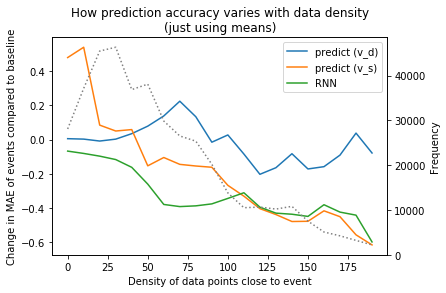

In [62]:
# MAE_dense_predict = np.array(MAE_dense_predict)
MAE_dense2_predict = np.array(MAE_dense2_predict)
MAE_baseline = np.array(MAE_baseline)
# MAE_sparse_predict = np.array(MAE_sparse_predict)
MAE_sparse2_predict = np.array(MAE_sparse2_predict)
MAE_RNN_predict = np.array(MAE_RNN_predict)


# plt.plot(x, percentages_baseline, label="baseline")
# plt.plot(x, MAE_dense_predict-MAE_baseline, label="predict (d)")
plt.plot(x, MAE_dense2_predict-MAE_baseline, label="predict (v_d)")
# plt.plot(x, MAE_sparse_predict-MAE_baseline, label="predict (s)")
plt.plot(x, MAE_sparse2_predict-MAE_baseline, label="predict (v_s)")
plt.plot(x, MAE_RNN_predict-MAE_baseline, label="RNN")

plt.xlabel("Density of data points close to event")
plt.ylabel("Change in MAE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
# ax2.set_yscale("log")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



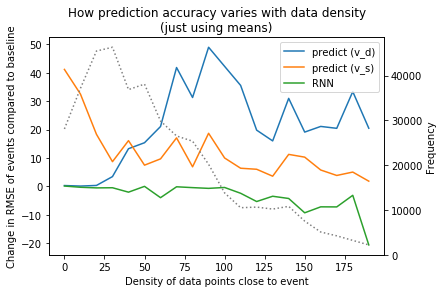

In [63]:
# RMSE_dense_predict = np.array(RMSE_dense_predict)
RMSE_dense2_predict = np.array(RMSE_dense2_predict)
RMSE_baseline = np.array(RMSE_baseline)
# RMSE_sparse_predict = np.array(RMSE_sparse_predict)
RMSE_sparse2_predict = np.array(RMSE_sparse2_predict)
RMSE_RNN_predict = np.array(RMSE_RNN_predict)


# plt.plot(x, percentages_baseline, label="mean")
# plt.plot(x, RMSE_dense_predict-RMSE_baseline, label="predict (d)")
plt.plot(x, RMSE_dense2_predict-RMSE_baseline, label="predict (v_d)")
# plt.plot(x, RMSE_sparse_predict-RMSE_baseline, label="predict (s)")
plt.plot(x, RMSE_sparse2_predict-RMSE_baseline, label="predict (v_s)")
plt.plot(x, RMSE_RNN_predict-RMSE_baseline, label="RNN")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in RMSE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



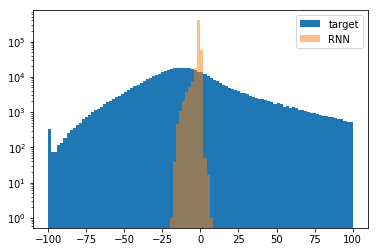

In [64]:
plt.hist(test_target, bins=100, range=(-100,100), label="target");
plt.hist(test_y, bins=100, range=(-100,100), alpha=0.5, label="RNN");
# plt.hist(st_offsets_dense[cut_point:,0,3], bins=100, range=(-100,100), alpha=0.5, label="Dense");
# plt.hist(offsets_sparse2[cut_point:], bins=100, range=(-100,100), alpha=0.5, label="Sparse");
plt.legend()
plt.yscale("log")


In [73]:
test_baseline_array_cum, test_actual_array_cum, baseline_pass_count, baseline_pass_fraction = calc_baseline_and_actual(test_mask)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


In [66]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=test_baseline_array_cum, actual_array_cum=test_actual_array_cum, calc_mask=test_mask)


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 1.95% improvment on baseline
Approximately 40.68% are in 10%


.............................................................................

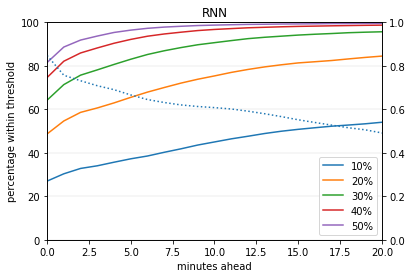

In [67]:
show_accuracy_minutes(predict_array_RNN_cum, test_actual_array_cum, title="RNN")

.............................................................................

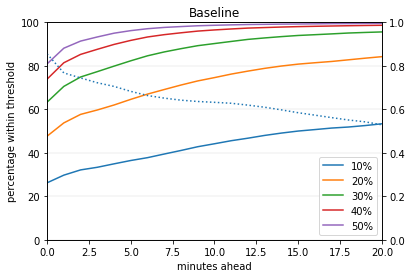

In [68]:
show_accuracy_minutes(test_baseline_array_cum, test_actual_array_cum, title="Baseline")

In [74]:
baseline_pass_fraction

0.3990746501786633

In [75]:
def full_test(dropout, rdropout, loss, filename):
    
    model = create_LSTM_large(
        (train_matrix_st.shape[1], train_matrix_st.shape[2]),
        dropout,
        rdropout,
    )

    Path(f"ST_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"ST_models/" + filename,
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_matrix_st,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=512,
        validation_data=(test_matrix_st, test_target_scaled),
    )

    test_y_scaled = model.predict(test_matrix_st)
    
    test_y = scaler_target.inverse_transform(test_y_scaled)
    
    print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
    print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
    
    predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=test_baseline_array_cum, actual_array_cum=test_actual_array_cum, calc_mask=test_mask)
    
    return pass_fraction, mean_absolute_error(test_target, test_y), np.sqrt(mean_squared_error(test_target, test_y))

In [ ]:
with open("lstm_test1.csv", "w") as f: 
    f.write("dropout,rdropout,loss,pass_fraction,MSE,RMSE\n")
    for runs in range(5):
        for i in np.linspace(0,.3,4):
            for j in np.linspace(0,.3,4):
                for loss in ['mean_absolute_error', 'mean_squared_error']:
                    pass_frac, MSE, RMSE = full_test(i,j,loss,f"lstm_run_{runs}_dropout_{i}_{j}_{loss}_80_128_64_32_12_12_1.h5")

                    f.write(f"{i},{j},{loss},{pass_frac},{MSE},{RMSE}\n")
                    f.flush()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_19 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
__________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 9.61% improvment on baseline
Approximately 43.74% are in 10%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_25 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 2.97% improvment on baseline
Approximately 41.09% are in 10%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_31 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 8.84% improvment on baseline
Approximately 43.44% are in 10%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_37 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 8.81% improvment on baseline
Approximately 43.42% are in 10%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 80)                28160     
_________________________________________________________________
dropout_43 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
d

In [ ]:
show_accuracy_minutes(predict_array_RNN_cum, actual_array_cum, "means")

In [37]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [38]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [72]:
def calc_baseline_and_actual(calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_pass_count, pass_fraction


In [ ]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(data_mask)

In [47]:
def calc_prediction_cum_journeys(column_name=None, offsets=None, baseline_array_cum=test_baseline_array_cum, actual_array_cum=test_actual_array_cum, calc_mask=data_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets.squeeze()/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [ ]:
def full_test(slices, threshold, baseline_array_cum, actual_array_cum, column_name=None, axis=(1,2), means=means, counts=counts, data_mask):
    try:
        offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, slices, axis, column_name, threshold)
    except ValueError:
        print("Not enough values passed threshold")
        return [], 0, 0, 0, 0
    
    predict_array_cum, pass_count, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, data_mask=data_mask)
    
    return predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights


In [ ]:
show_accuracy_minutes(baseline_array_cum, actual_array_cum, "means")

In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

predict_array_dense2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense2_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

predict_array_dense_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense_cum, actual_array_cum, "means")


In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

predict_array_sparse_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

predict_array_sparse2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse2_cum, actual_array_cum, "means")


In [ ]:
# dense_mask = (bus_counts>40)

# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="mean sparse")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="predict sparse")
# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="mean dense")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="predict dense")


# # plt.plot(results_enh7[0,:], label="mean_enh7")
# # plt.plot(predict_array_cum[0,:], label="mean_enh_all")
# # plt.plot(with_15_90[0,:], label="with_15_90")
# # plt.plot(narrow_15_90[0,:], label="narrow_15_90")
# # plt.plot(narrow_15_90_t40[0,:], label="narrow_15_90_t40")
# # plt.plot(wide_15_45_t20[0,:], label="wide_15_45_t20")

# plt.legend()
# plt.xlim(0,20)
# plt.ylim(25,60)
# plt.title("Percentage of predictions within 10%")
# plt.xlabel("minutes ahead")
# plt.ylabel("percent within 10%")
# plt.show()

In [ ]:
first_20mins_mask = actual_array_cum < 20*60

In [ ]:
percentages_baseline = []
percentage_dense2_predict = []
percentage_dense_predict = []
percentage_sparse_predict = []
percentage_sparse2_predict = []
percentage_ave_predict = []

freqeuncy = []

x = np.array(range(27))*10

for i in x:

    if forwards: 
        full_mask = first_20mins_mask & (bus_counts>i)[:data_size,None] & (bus_counts<i+10)[:data_size,None]
    else:
        full_mask = first_20mins_mask & (bus_counts>i)[-data_size:,None] & (bus_counts<i+10)[-data_size:,None]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    percentages_baseline.append(np.count_nonzero((baseline_array_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (baseline_array_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_dense2_predict.append(np.count_nonzero((predict_array_dense2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
        
    percentage_dense_predict.append(np.count_nonzero((predict_array_dense_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse_predict.append(np.count_nonzero((predict_array_sparse_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse2_predict.append(np.count_nonzero((predict_array_sparse2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    

In [ ]:
percentage_dense_predict = np.array(percentage_dense_predict)
percentage_dense2_predict = np.array(percentage_dense2_predict)
percentages_baseline = np.array(percentages_baseline)
percentage_sparse_predict = np.array(percentage_sparse_predict)
percentage_sparse2_predict = np.array(percentage_sparse2_predict)


# plt.plot(x, percentages_baseline, label="mean")
plt.plot(x, percentage_dense_predict-percentages_baseline, label="predict (d)")
plt.plot(x, percentage_dense2_predict-percentages_baseline, label="predict (v_d)")
plt.plot(x, percentage_sparse_predict-percentages_baseline, label="predict (s)")
plt.plot(x, percentage_sparse2_predict-percentages_baseline, label="predict (v_s)", ls=":")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in % of events within 10% of true\nCompared to Baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()


In [ ]:
# baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

In [ ]:
# with open("post_noise_width_time_threshold_test3.csv", "w") as f: 
#     f.write("width,time,threshold,threshold_pass_fraction,mean_weights,pass_count,pass_fraction\n")
#     for width in range(0,12,2):
#         for time in range(2,24,3):
#             for threshold in [0,20,40,60,80,100,120,140,160,180,200,250,300]:
#                 print(f"w: {width}, t:20-{(time+3)*10}, t:{threshold}")
#     #             _, _, _, pass_count = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, number_of_rows=50000)
#                 predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,2:time+3,11-width:11+width+1], threshold, baseline_array_cum, actual_array_cum, number_of_rows=500000)
        
#                 f.write(f"{width},{(time+3)*10},{threshold},{threshold_pass_fraction},{mean_weights},{pass_count},{pass_fraction}\n")
#                 f.flush()
    
            
            